In [1]:
import sys
print(sys.executable)

c:\Python312\python.exe


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Configuration graphique [cite: 21, 22]
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

print("Bibliothèques importées avec succès")

# Chargement du jeu de données [cite: 25]
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# Inspection de base
print(f"Dimensions du dataset : {df.shape[0]} lignes, {df.shape[1]} colonnes") 
print("\nDescription des variables :")

# Dictionnaire des descriptions fourni dans le document [cite: 29]
descriptions = {
    'MedInc': 'Revenu médian du quartier',
    'HouseAge': 'Âge médian des logements',
    'AveRooms': 'Nombre moyen de pièces par logement',
    'AveBedrms': 'Nombre moyen de chambres par logement',
    'Population': 'Population du quartier',
    'AveOccup': "Nombre moyen d'occupants par logement",
    'Latitude': 'Latitude géographique',
    'Longitude': 'Longitude géographique',
    'MedHouseVal': 'Prix médian du logement (cible)'
}

for col, desc in descriptions.items():
    print(f"{col:15s} : {desc}")

# Aperçu des données
print("\n--- Premières lignes (head) ---")
print(df.head()) 

print("\n--- Infos techniques (info) ---")
print(df.info()) 

print("\n--- Statistiques descriptives (describe) ---")
print(df.describe()) 

Bibliothèques importées avec succès
Dimensions du dataset : 20640 lignes, 9 colonnes

Description des variables :
MedInc          : Revenu médian du quartier
HouseAge        : Âge médian des logements
AveRooms        : Nombre moyen de pièces par logement
AveBedrms       : Nombre moyen de chambres par logement
Population      : Population du quartier
AveOccup        : Nombre moyen d'occupants par logement
Latitude        : Latitude géographique
Longitude       : Longitude géographique
MedHouseVal     : Prix médian du logement (cible)

--- Premières lignes (head) ---
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       5


--- 2. Nettoyage des Données ---
Valeurs manquantes :
 Series([], dtype: int64)
Nombre de doublons trouvés : 0
Dimensions après suppression des outliers extrêmes : (20620, 9)


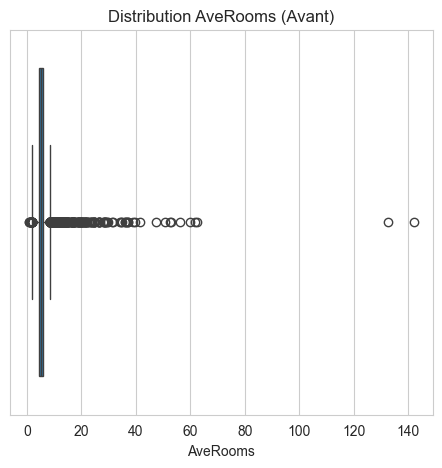

In [5]:
print("\n--- 2. Nettoyage des Données ---")

# 1. Vérifier les valeurs manquantes [cite: 48]
missing_values = df.isnull().sum()
print("Valeurs manquantes :\n", missing_values[missing_values > 0])
# Note : Le dataset California Housing est généralement propre, mais c'est une bonne pratique.

# 2. Vérifier et supprimer les doublons [cite: 50]
duplicates = df.duplicated().sum()
print(f"Nombre de doublons trouvés : {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()

# 3. Détecter et filtrer les outliers (valeurs aberrantes) [cite: 51, 53]

# Visualisation avant nettoyage (Optionnel pour vérifier)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['AveRooms'])
plt.title('Distribution AveRooms (Avant)')

# Application des filtres suggérés [cite: 53]

df_clean = df[(df['AveRooms'] < 50) & (df['AveOccup'] < 20) & (df['AveBedrms'] < 10)]

print(f"Dimensions après suppression des outliers extrêmes : {df_clean.shape}")

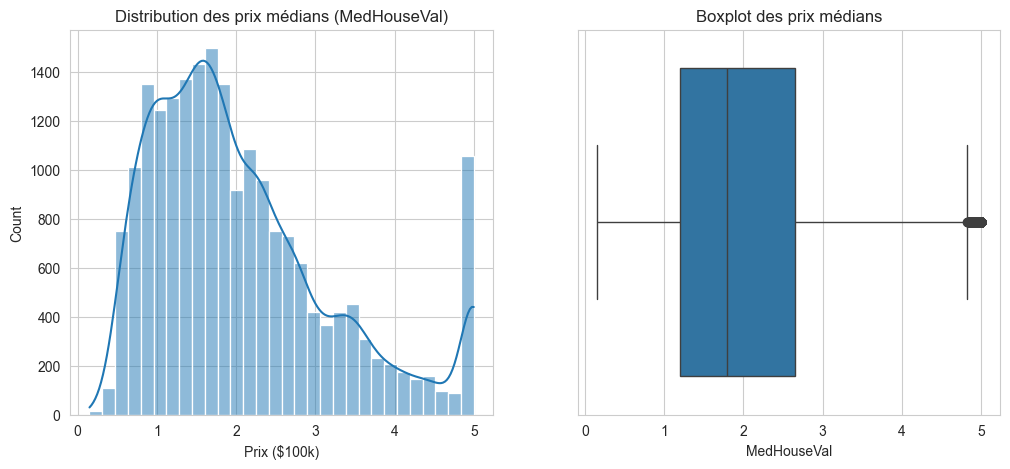

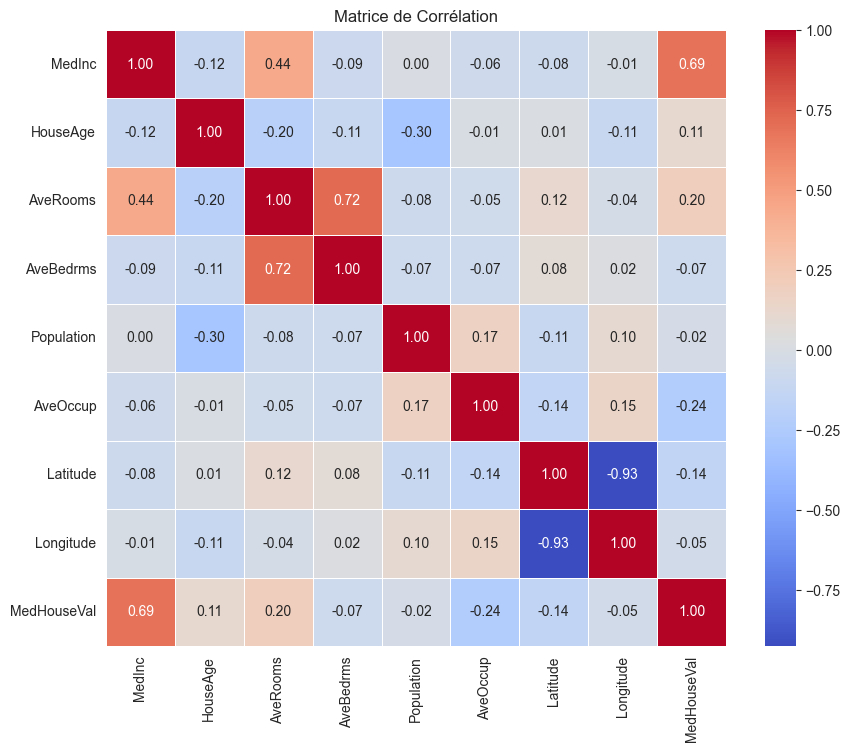

In [6]:
# --- 3. Analyse Exploratoire (EDA) ---

# A. Distribution de la variable cible (MedHouseVal)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['MedHouseVal'], kde=True, bins=30)
plt.title('Distribution des prix médians (MedHouseVal)')
plt.xlabel('Prix ($100k)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean['MedHouseVal'])
plt.title('Boxplot des prix médians')
plt.show()

# B. Matrice de corrélation (Heatmap)
# Permet d'identifier les variables fortement liées au prix[cite: 58].
plt.figure(figsize=(10, 8))
corr_matrix = df_clean.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

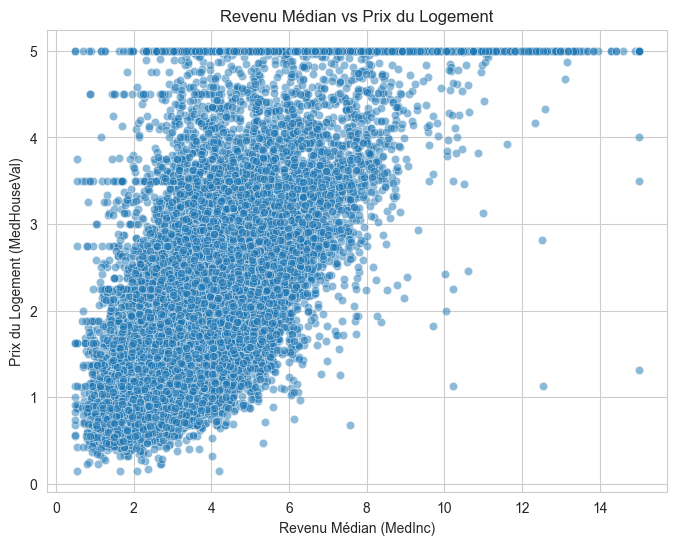

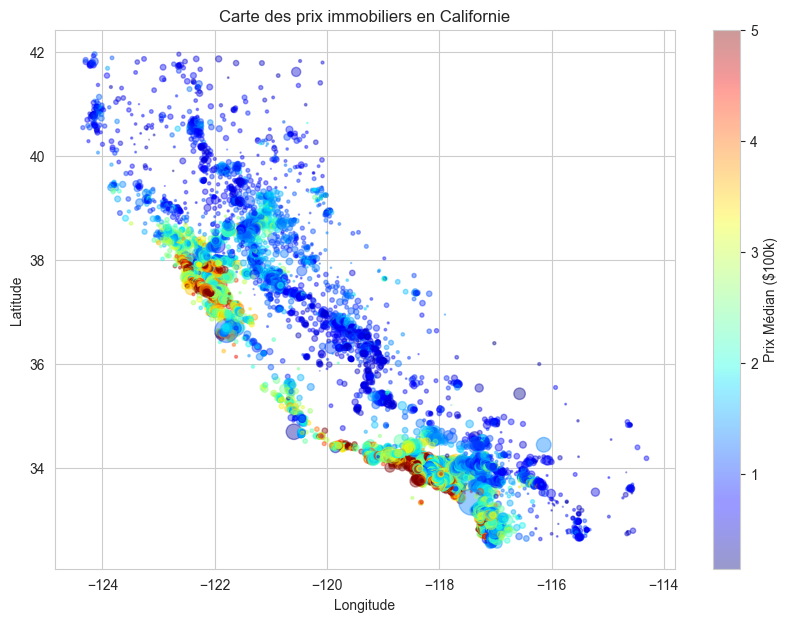

In [7]:
# C. Scatter Plot : Relation Revenu vs Prix
# On s'attend à une relation positive forte entre MedInc et MedHouseVal[cite: 67].
plt.figure(figsize=(8, 6))
sns.scatterplot(x='MedInc', y='MedHouseVal', data=df_clean, alpha=0.5)
plt.title('Revenu Médian vs Prix du Logement')
plt.xlabel('Revenu Médian (MedInc)')
plt.ylabel('Prix du Logement (MedHouseVal)')
plt.show()

# D. Carte Géographique des prix
# Visualiser la répartition spatiale (Latitude/Longitude) colorée par le prix[cite: 68, 69].
plt.figure(figsize=(10, 7))
sc = plt.scatter(x=df_clean['Longitude'], y=df_clean['Latitude'],
                 c=df_clean['MedHouseVal'], cmap='jet', alpha=0.4, s=df_clean['Population']/100)
plt.colorbar(sc, label='Prix Médian ($100k)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Carte des prix immobiliers en Californie')
plt.show()

In [8]:
# --- 4. Ingénierie des variables ---

# Création de nouvelles features calculées[cite: 73]:
# 1. Ratio Pièces / Chambres
df_clean['RoomsPerBedroom'] = df_clean['AveRooms'] / df_clean['AveBedrms'] # [cite: 74]

# 2. Estimation du nombre de logements (Population / Occupants par logement)
df_clean['PopPerHousehold'] = df_clean['Population'] / df_clean['AveOccup'] # [cite: 75]

# Vérification des nouvelles colonnes
print("Nouvelles variables ajoutées :")
print(df_clean[['RoomsPerBedroom', 'PopPerHousehold']].head())

Nouvelles variables ajoutées :
   RoomsPerBedroom  PopPerHousehold
0         6.821705            126.0
1         6.418626           1138.0
2         7.721053            177.0
3         5.421277            219.0
4         5.810714            259.0


In [9]:
# --- 5. Séparation des données ---

# Définition de X (features) et y (cible)
# On exclut la cible 'MedHouseVal' de X [cite: 79, 81]
X = df_clean.drop('MedHouseVal', axis=1)
y = df_clean['MedHouseVal']

# Division en ensembles d'entraînement et de test
# 80% pour l'entraînement, 20% pour le test [cite: 84]
# random_state=42 garantit la reproductibilité [cite: 85]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensions de l'entraînement (X_train) : {X_train.shape}")
print(f"Dimensions du test (X_test) : {X_test.shape}")

Dimensions de l'entraînement (X_train) : (16496, 10)
Dimensions du test (X_test) : (4124, 10)


In [10]:
# --- 6. Construction et Entraînement ---

from sklearn.metrics import mean_absolute_error # Import manquant dans le bloc 1

# Instanciation du modèle
model = LinearRegression()

# Entraînement sur les données d'apprentissage (fit)
print("Entraînement du modèle en cours...")
model.fit(X_train, y_train)

# Affichage des paramètres du modèle
print(f"\nOrdonnée à l'origine (Intercept beta_0) : {model.intercept_:.4f}")
print("Coefficients (beta_n) par variable :")

# Création d'un tableau pour lire facilement les coefficients
coef_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_})
print(coef_df.sort_values(by='Coefficient', ascending=False))

# Interprétation rapide :
# Un coef positif augmente le prix, un coef négatif le diminue [cite: 95]

Entraînement du modèle en cours...

Ordonnée à l'origine (Intercept beta_0) : -33.5301
Coefficients (beta_n) par variable :
          Variable  Coefficient
0           MedInc     0.440050
2         AveRooms     0.089642
1         HouseAge     0.010921
9  PopPerHousehold     0.000643
4       Population    -0.000183
5         AveOccup    -0.175447
3        AveBedrms    -0.213081
8  RoomsPerBedroom    -0.227512
7        Longitude    -0.416648
6         Latitude    -0.418171


In [11]:
# --- 7. Prédiction et Évaluation ---

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)      # Moyenne des erreurs au carré [cite: 100]
rmse = np.sqrt(mse)                           # Racine de l'erreur quadratique (même unité que le prix) [cite: 104]
mae = mean_absolute_error(y_test, y_pred)     # Moyenne des écarts absolus [cite: 105]
r2 = r2_score(y_test, y_pred)                 # Score R2 (Variance expliquée) [cite: 109]

print("\n--- Performances du modèle ---")
print(f"MSE (Mean Squared Error) : {mse:.4f}")
print(f"RMSE (Root Mean Squared Error) : {rmse:.4f}")
print(f"MAE (Mean Absolute Error) : {mae:.4f}")
print(f"R² Score : {r2:.4f}")

# Interprétation R2 :
# 1.0 = Prédiction parfaite. 0.0 = Modèle équivalent à la moyenne simple. [cite: 110, 115]


--- Performances du modèle ---
MSE (Mean Squared Error) : 0.4560
RMSE (Root Mean Squared Error) : 0.6753
MAE (Mean Absolute Error) : 0.4904
R² Score : 0.6483


C:\Users\Volahanitra\AppData\Local\Temp\ipykernel_21496\3272906095.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Variable', data=coef_sorted, palette='viridis')


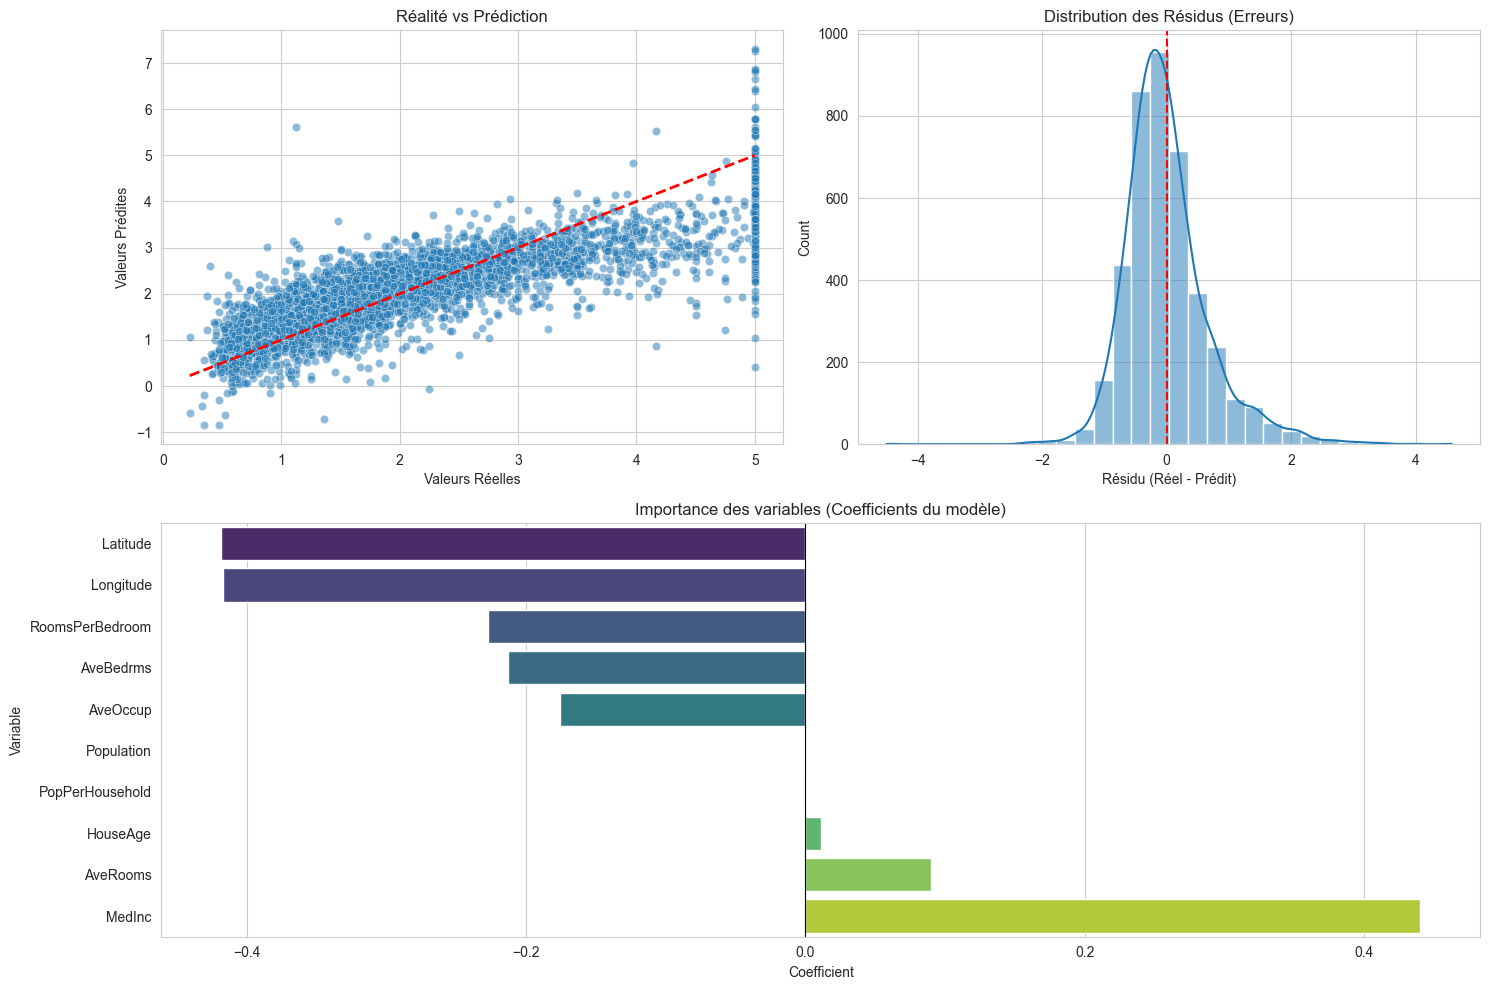

In [12]:
# --- 8. Visualisation des résultats ---
plt.figure(figsize=(15, 10))

# Graphique 1 : Valeurs Réelles vs Prédites [cite: 117]
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
# Ligne diagonale rouge (idéale)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Réalité vs Prédiction')

# Graphique 2 : Distribution des résidus (Histogramme) [cite: 122]
residus = y_test - y_pred
plt.subplot(2, 2, 2)
sns.histplot(residus, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution des Résidus (Erreurs)')
plt.xlabel('Résidu (Réel - Prédit)')

# Graphique 3 : Importance des variables (Barplot des coefficients) [cite: 126]
plt.subplot(2, 1, 2)
# On trie pour mieux voir
coef_sorted = coef_df.sort_values(by='Coefficient')
sns.barplot(x='Coefficient', y='Variable', data=coef_sorted, palette='viridis')
plt.title('Importance des variables (Coefficients du modèle)')
plt.axvline(x=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

In [13]:
# --- 9. Export des résultats ---

# Création du DataFrame final
resultats_df = X_test.copy()
resultats_df['Prix_Reel'] = y_test
resultats_df['Prix_Predit'] = y_pred
resultats_df['Residu'] = residus
# Calcul de l'erreur en pourcentage (Attention aux divisions par zéro théoriques)
resultats_df['Erreur_Pct'] = np.abs(resultats_df['Residu'] / resultats_df['Prix_Reel']) * 100

# Aperçu des résultats
print("\n--- Aperçu du fichier exporté ---")
print(resultats_df[['Prix_Reel', 'Prix_Predit', 'Residu', 'Erreur_Pct']].head())

# Export en CSV
resultats_df.to_csv("resultats_regression.csv", index=False)
print("\nFichier 'resultats_regression.csv' exporté avec succès.")


--- Aperçu du fichier exporté ---
       Prix_Reel  Prix_Predit    Residu  Erreur_Pct
6151       1.310     1.579415 -0.269415   20.566039
16208      0.608     0.647815 -0.039815    6.548440
15978      3.900     2.889162  1.010838   25.918923
18375      3.627     3.526002  0.100998    2.784616
8402       1.485     1.403930  0.081070    5.459246

Fichier 'resultats_regression.csv' exporté avec succès.
